In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense,LSTM
from sklearn import metrics
from datetime import timedelta, date, datetime
import time

In [2]:
from google.colab import files
import io
uploaded = files.upload()

Saving Global DataBase2 daily.csv to Global DataBase2 daily.csv
Saving Global DataBase3.csv to Global DataBase3.csv


In [3]:
df1=pd.read_csv(io.BytesIO(uploaded['Global DataBase2 daily.csv']), index_col='datetime_per_day', parse_dates=True)

df2=pd.read_csv(io.BytesIO(uploaded['Global DataBase3.csv']), index_col='datetime', parse_dates=True)


df1 = df1.loc['2017-01-01':'2020-12-31']
df2 = df2.loc['2017-01-01':'2020-12-31']

index = pd.date_range(start='2017-01-01', end='2022-02-28', freq="1d")
columns = ["datetime_per_week", 'Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA','Wind Onshore AA','Electricity Consumption (MWh)']

df = pd.DataFrame(np.nan, index=range(0,index.size), columns=columns)
df["datetime_per_week"] = index
df.set_index("datetime_per_week", inplace=True)

df = df.resample("W").mean()


columns1 = ['Electricity Consumption (MWh)']
for column in columns1 : 
    df[column] = df2[column].resample("W").sum()
columns2=['Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA','Wind Onshore AA']
for column in columns2 : 
    df[column] = df2[column].resample("W").mean()
df = df.sort_index()

#Handeling global outliers
GlobalOutliers =  []
for i in range(3):
    GlobalOutliers.append(df.idxmax()['Price - PT [€/MWh]'])
    df.at[df.idxmax()['Price - PT [€/MWh]'], 'Price - PT [€/MWh]'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, 'Price - PT [€/MWh]'] = df[sdt:edt]['Price - PT [€/MWh]'].mean()
    
#Handling negative values 
negativeIndex = df.index[df['Price - PT [€/MWh]'] < 0]
for index in (negativeIndex):
    df.at[index, 'Price - PT [€/MWh]']= df.at[index - timedelta(hours=1), 'Price - PT [€/MWh]']
    
df = df.dropna()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  import sys


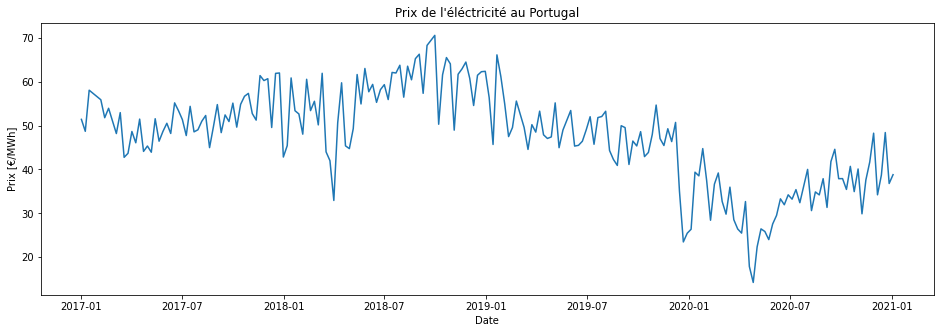

In [4]:
#Plot Price after data cleaning
plt.figure(figsize=(16,5))
plt.gca().set(title="Prix de l'éléctricité au Portugal", xlabel='Date', ylabel='Prix [€/MWh]')
plt.plot(df.index, df['Price - PT [€/MWh]'])  
plt.show()

In [5]:
df_u=df[['Price - PT [€/MWh]']].dropna()
df_u

,Price - PT [€/MWh]
datetime_per_week,
2017-01-01,51.421739
2017-01-08,48.699821
2017-01-15,58.071190
2017-02-05,55.892917
2017-02-12,51.798393
...,...
2020-12-06,34.227024
2020-12-13,38.731071
2020-12-20,48.421369


In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(df_u.values)
    
reframed= series_to_supervised(scaled, 10)
reframed

,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
10,0.319984,0.223320,0.556127,0.478770,0.333360,0.409718,0.308917,0.205174,0.374547,0.012712,0.045308
11,0.223320,0.556127,0.478770,0.333360,0.409718,0.308917,0.205174,0.374547,0.012712,0.045308,0.221855
12,0.556127,0.478770,0.333360,0.409718,0.308917,0.205174,0.374547,0.012712,0.045308,0.221855,0.130455
13,0.478770,0.333360,0.409718,0.308917,0.205174,0.374547,0.012712,0.045308,0.221855,0.130455,0.322110
14,0.333360,0.409718,0.308917,0.205174,0.374547,0.012712,0.045308,0.221855,0.130455,0.322110,0.060693
...,...,...,...,...,...,...,...,...,...,...,...
202,-0.160250,-0.159567,-0.247078,-0.060393,-0.264811,-0.081588,-0.444544,-0.170965,-0.025264,0.208168,-0.290655
203,-0.159567,-0.247078,-0.060393,-0.264811,-0.081588,-0.444544,-0.170965,-0.025264,0.208168,-0.290655,-0.130702
204,-0.247078,-0.060393,-0.264811,-0.081588,-0.444544,-0.170965,-0.025264,0.208168,-0.290655,-0.130702,0.213431
205,-0.060393,-0.264811,-0.081588,-0.444544,-0.170965,-0.025264,0.208168,-0.290655,-0.130702,0.213431,-0.199027


In [8]:
#values = reframed_differenced.values
values = reframed.values
n_train_days=  int(len(values) * 0.5)
n_val_days= int(len(values) * 0.75)
train = values[:n_train_days, :]
val= values[n_train_days:n_val_days, :]
test = values[n_val_days:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(test_X)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X= val_X.reshape((val_X.shape[0], 1,val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(test_X)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

index_test=df_u['Price - PT [€/MWh]'][n_val_days:]

[[ 0.10829941  0.24412685  0.14018942  0.29528488 -0.26079903 -0.67208208
  -0.60154398 -0.56939185 -0.10756378 -0.13717714]
 [ 0.24412685  0.14018942  0.29528488 -0.26079903 -0.67208208 -0.60154398
  -0.56939185 -0.10756378 -0.13717714  0.08347611]
 [ 0.14018942  0.29528488 -0.26079903 -0.67208208 -0.60154398 -0.56939185
  -0.10756378 -0.13717714  0.08347611 -0.1739164 ]
 [ 0.29528488 -0.26079903 -0.67208208 -0.60154398 -0.56939185 -0.10756378
  -0.13717714  0.08347611 -0.1739164  -0.49654116]
 [-0.26079903 -0.67208208 -0.60154398 -0.56939185 -0.10756378 -0.13717714
   0.08347611 -0.1739164  -0.49654116 -0.20458036]
 [-0.67208208 -0.60154398 -0.56939185 -0.10756378 -0.13717714  0.08347611
  -0.1739164  -0.49654116 -0.20458036 -0.11386315]
 [-0.60154398 -0.56939185 -0.10756378 -0.13717714  0.08347611 -0.1739164
  -0.49654116 -0.20458036 -0.11386315 -0.34464612]
 [-0.56939185 -0.10756378 -0.13717714  0.08347611 -0.1739164  -0.49654116
  -0.20458036 -0.11386315 -0.34464612 -0.44724757]
 

In [9]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [10]:
# fit network
start_time=time.time()
history = model.fit(train_X, train_y, epochs=200, batch_size=100, validation_data=(val_X, val_y), verbose=0, shuffle=False)
exec_time= time.time()-start_time

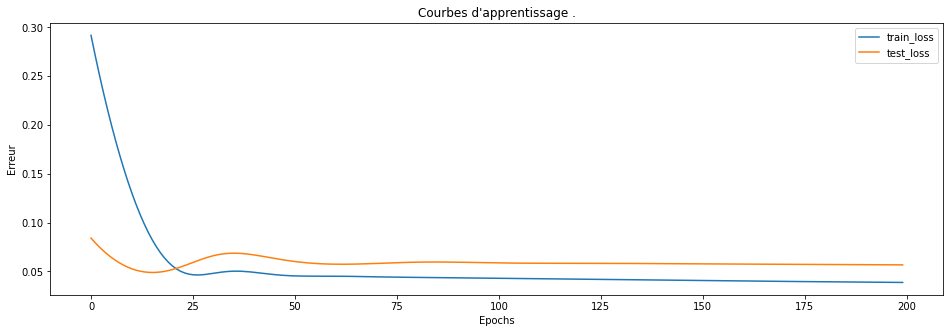

In [11]:
# plot history
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.gca().set(title='Courbes d\'apprentissage .', xlabel='Epochs', ylabel='Erreur')
plt.legend()

In [12]:
# make a prediction
print(test_X.shape)
yhat = model.predict(test_X)
#Transform test to be 2D
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

(50, 1, 10)


In [13]:
test_X=pd.DataFrame(test_X)
# invert scaling for forecast
test_X[0]= yhat
inv_yhat = scaler.inverse_transform(test_X)
inv_yhat = inv_yhat[:,0]

In [14]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_X[0]= test_y
inv_y = scaler.inverse_transform(test_X)
inv_y = inv_y[:,0]

In [15]:
#Calculate MAE, MSE, RMSE, CV
MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
MSE=metrics.mean_squared_error(inv_y, inv_yhat)
CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
R2= metrics.r2_score(inv_y, inv_yhat)

print('Mean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)  
print('Root Mean Squared Error:', np.sqrt(MSE))
print('Coefficient of Variance:',CV)
print('R2:', R2)
print('exec_time:', exec_time)

Mean Absolute Error: 7.041290206040739
Mean Squared Error: 70.20208829017054
Root Mean Squared Error: 8.378668646638948
Coefficient of Variance: 24.644930828190297
R2: -0.4777058786242716
exec_time: 10.942146301269531


[Text(0, 0.5, 'Price [€/MWh]'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, "Prix de l'éléctricité au Portugal")]

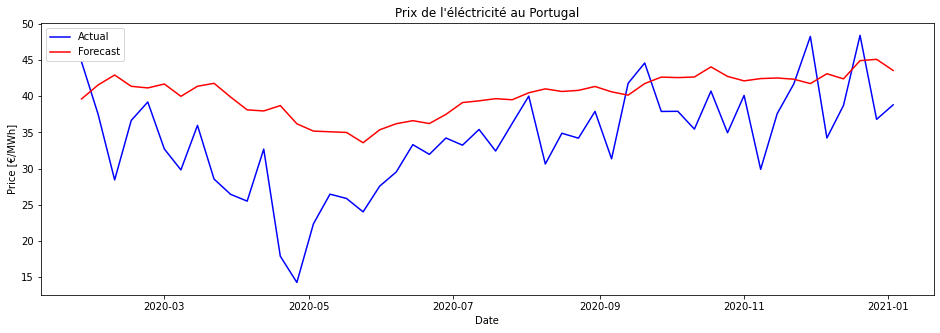

In [16]:
plt.figure(figsize=(16,5))
plt.plot(index_test[10:].index, inv_y, color='blue')
plt.plot(index_test[10:].index, inv_yhat, color='red')
plt.legend(('Actual', 'Forecast'))
plt.gca().set(title="Prix de l'éléctricité au Portugal", xlabel='Date', ylabel='Price [€/MWh]')

In [17]:
# BEST n_in

score = []
best_n = 1
best_score = 0

for n in range(best_n, 30):
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaled = scaler.fit_transform(df_u.values)
  reframed= series_to_supervised(scaled, n)
  
  #values = reframed_differenced.values
  values = reframed.values
  n_train_days=  int(len(values) * 0.5)
  n_val_days= int(len(values) * 0.75)
  train = values[:n_train_days, :]
  val= values[n_train_days:n_val_days, :]
  test = values[n_val_days:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  val_X, val_y = val[:, :-1], val[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  val_X= val_X.reshape((val_X.shape[0], 1,val_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  index_test=df_u['Price - PT [€/MWh]'][n_val_days:]
    # design network
  model = Sequential()
  model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  # fit network
  start_time=time.time()
  history = model.fit(train_X, train_y, epochs=200, batch_size=100, validation_data=(val_X, val_y), verbose=0, shuffle=False)
  exec_time= time.time()-start_time
  # make a prediction
  
  yhat = model.predict(test_X)
  #Transform test to be 2D
  test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
  test_X=pd.DataFrame(test_X)
  # invert scaling for forecast
  test_X[0]= yhat
  inv_yhat = scaler.inverse_transform(test_X)
  inv_yhat = inv_yhat[:,0]
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  test_X[0]= test_y
  inv_y = scaler.inverse_transform(test_X)
  inv_y = inv_y[:,0]
  #Calculate MAE, MSE, RMSE, CV
  MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
  MSE=metrics.mean_squared_error(inv_y, inv_yhat)
  CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
  R2= metrics.r2_score(inv_y, inv_yhat)
  print(n)

  print('Mean Absolute Error:', MAE)
  print('Mean Squared Error:', MSE)  
  print('Root Mean Squared Error:', np.sqrt(MSE))
  print('Coefficient of Variance:',CV)
  print('R2:', R2)
  print('exec_time:', exec_time)
  print("*************************")



  if best_score < R2:
        best_n = n
print('best_n' , best_n)

1
Mean Absolute Error: 9.967555697793925
Mean Squared Error: 130.04557625631713
Root Mean Squared Error: 11.403752726901663
Coefficient of Variance: 33.3554087349499
R2: -1.7906911265069465
exec_time: 6.746993780136108
*************************
2
Mean Absolute Error: 11.549395524230913
Mean Squared Error: 167.89705046277234
Root Mean Squared Error: 12.957509423603454
Coefficient of Variance: 37.90006968422626
R2: -2.6029584579612903
exec_time: 6.444782018661499
*************************
3
Mean Absolute Error: 18.760017113316966
Mean Squared Error: 407.93529673630076
Root Mean Squared Error: 20.197408168779994
Coefficient of Variance: 59.25291921729252
R2: -7.684250849742517
exec_time: 6.522901296615601
*************************


4
Mean Absolute Error: 8.145558287832207
Mean Squared Error: 89.68054196209742
Root Mean Squared Error: 9.469981096184798
Coefficient of Variance: 27.78198173708638
R2: -0.9091466930432219
exec_time: 6.590777158737183
*************************


5
Mean Absolute Error: 6.743258395729906
Mean Squared Error: 65.54280827023285
Root Mean Squared Error: 8.095851299908666
Coefficient of Variance: 23.750711926008318
R2: -0.39529526610985766
exec_time: 6.5317442417144775
*************************
6
Mean Absolute Error: 7.079467716758391
Mean Squared Error: 70.81713085308584
Root Mean Squared Error: 8.41529148949018
Coefficient of Variance: 24.687850176117436
R2: -0.5075766517570668
exec_time: 6.322731256484985
*************************
7
Mean Absolute Error: 6.57773417289847
Mean Squared Error: 62.788601672604706
Root Mean Squared Error: 7.923925900246967
Coefficient of Variance: 23.307355134234754
R2: -0.3216570626602986
exec_time: 5.37360954284668
*************************
8
Mean Absolute Error: 6.4957537918995465
Mean Squared Error: 62.28834532171232
Root Mean Squared Error: 7.892296580952361
Coefficient of Variance: 23.21432097582213
R2: -0.31112700908871127
exec_time: 6.337964057922363
*************************
9
Mean Absolute Err

KeyboardInterrupt: ignored